In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator

In [2]:
df_train = pd.read_csv('df_train.csv')
df_test  = pd.read_csv('df_test.csv')

In [3]:
# df_train

## Explonatory Data Analysis

Independent variable (Target) is `SalePrice`

In [4]:
df_train.SalePrice.dtypes

dtype('int64')

1.8828757597682129


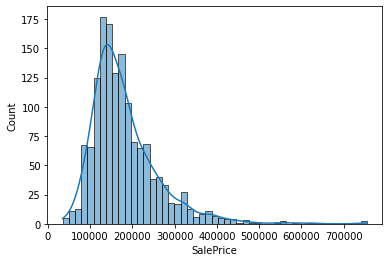

In [5]:
sns.histplot(data=df_train,x="SalePrice", kde=True)
print(df_train.SalePrice.skew())

We will adjust skewness later

In [6]:
# df_train['SalePrice'] = np.log(df_train['SalePrice']
# sns.histplot(data=df_train,x="SalePrice", kde=True)
# sns.histplot(data=df_train,x="SalePrice", kde=True)

In [7]:
numerical_features = list(df_train.select_dtypes('number').columns[:-1])
categorical_features = list(df_train.select_dtypes('object').columns)

print('The number of numerical features is ', len(numerical_features)) 
print('The number of catergorical features is ', len(categorical_features)) 

The number of numerical features is  33
The number of catergorical features is  28


### Numerical data

In [8]:
# we separate numerical features whose number of unique values <= 30 
numerical_features_less_30 = list(df_train[numerical_features].nunique()
                              .iloc[df_train[numerical_features].nunique().values<=30].index)
numerical_features_more_30 = [x for x in numerical_features if x not in numerical_features_less_30]

#### Numerical features whose number of unique values is $>30$ 

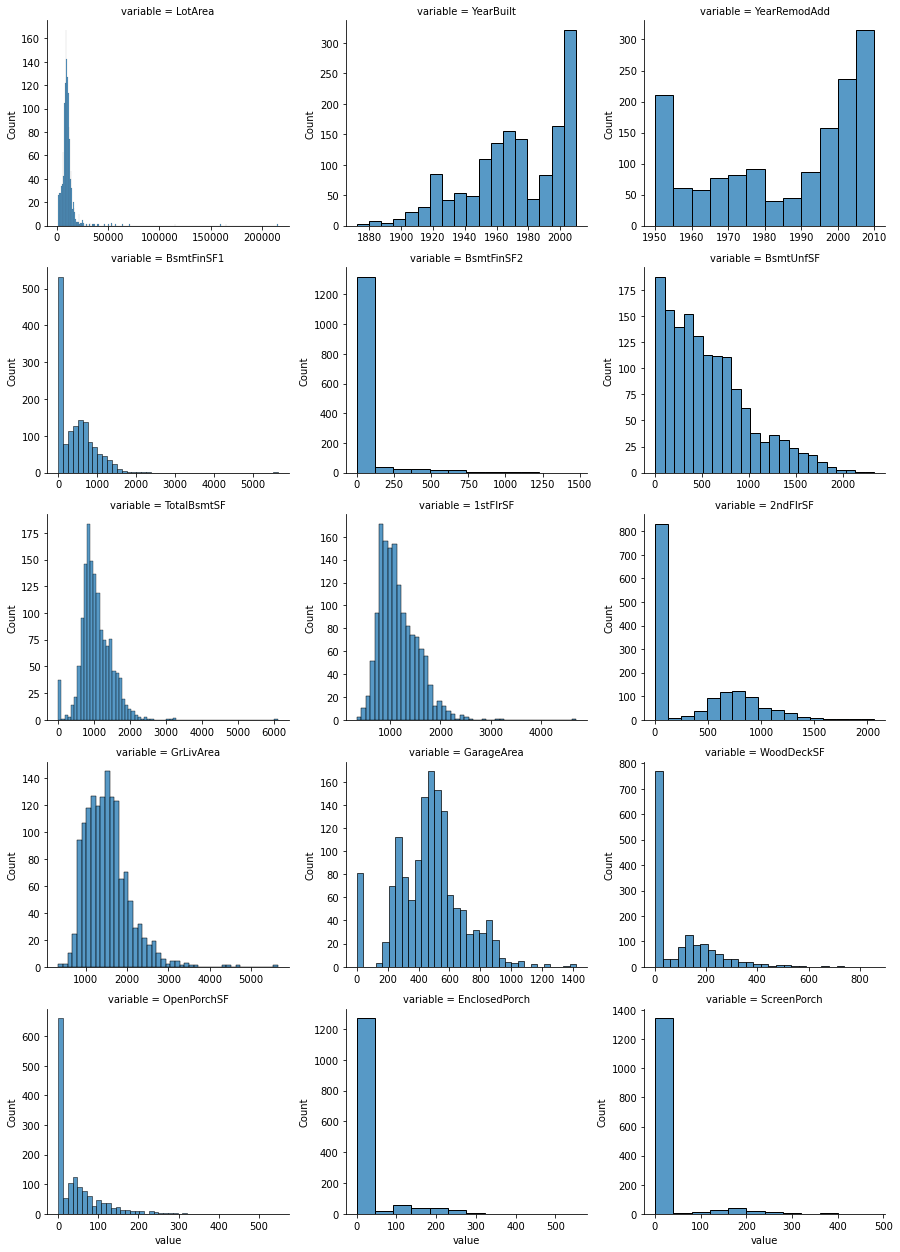

In [9]:
f = pd.melt(df_train[numerical_features_more_30])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
fg.map(sns.histplot, "value")

In [10]:
numerical_features_more_30 =['LotArea', 'TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea']

In [11]:
df_train[numerical_features_more_30].describe().min()

LotArea        1300.0
TotalBsmtSF       0.0
1stFlrSF        334.0
GrLivArea       334.0
GarageArea        0.0
dtype: float64

In [12]:
adjust_features = numerical_features_more_30 + ['SalePrice']
df_train[adjust_features] = df_train[adjust_features]/df_train[adjust_features].mean() + 0.1

In [13]:
# adjust_features = numerical_features_more_30 + ['SalePrice']
# df_train[adjust_features] = df_train[adjust_features] +1

### Method 1

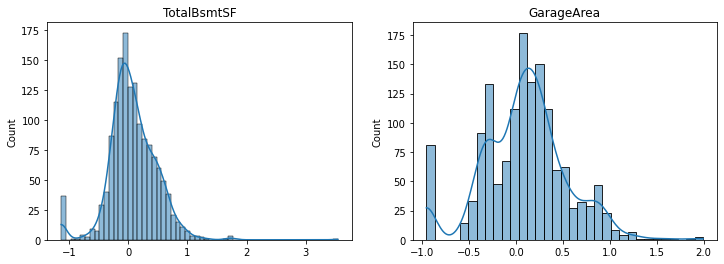

In [14]:
fig, axs = plt.subplots(ncols=2,figsize=(12,4))
xt1, _ = stats.boxcox(df_train.TotalBsmtSF)
sns.histplot(data=xt1, kde=True,ax=axs[0])
axs[0].set_title('TotalBsmtSF')
df_train.TotalBsmtSF = xt1

xt2, _ = stats.boxcox(df_train.GarageArea)
sns.histplot(data=xt2, kde=True,ax=axs[1])
axs[1].set_title('GarageArea')
df_train.GarageArea = xt2

In [15]:
df_train[['LotArea', '1stFlrSF','GrLivArea']] = np.log(df_train[['LotArea', '1stFlrSF','GrLivArea']])

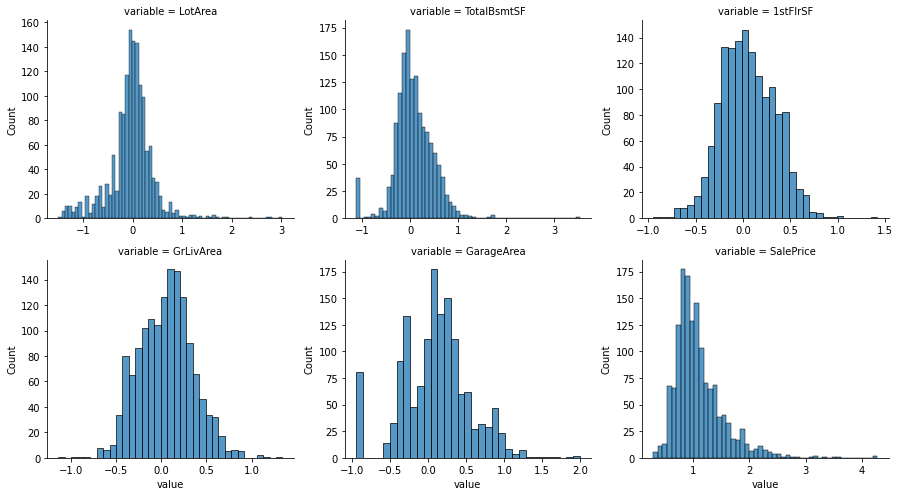

In [16]:
f = pd.melt(df_train[adjust_features])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
fg.map(sns.histplot, "value")

### Method 2


In [17]:
# nrows = len(adjust_features)//2 
# fig, axs = plt.subplots(ncols=2,nrows=nrows,figsize=(16,12))
# for i in range(nrows):
#     for j in range(2):
#         ftr = adjust_features[2*i+j]
#         xt, _ = stats.boxcox(df_train[ftr])
#         sns.histplot(data=xt, kde=True,ax=axs[i][j])
#         axs[i][j].set_title(ftr)
#         df_train[ftr] = xt
        

#### Numerical features whose number of unique values is $\leq 30$

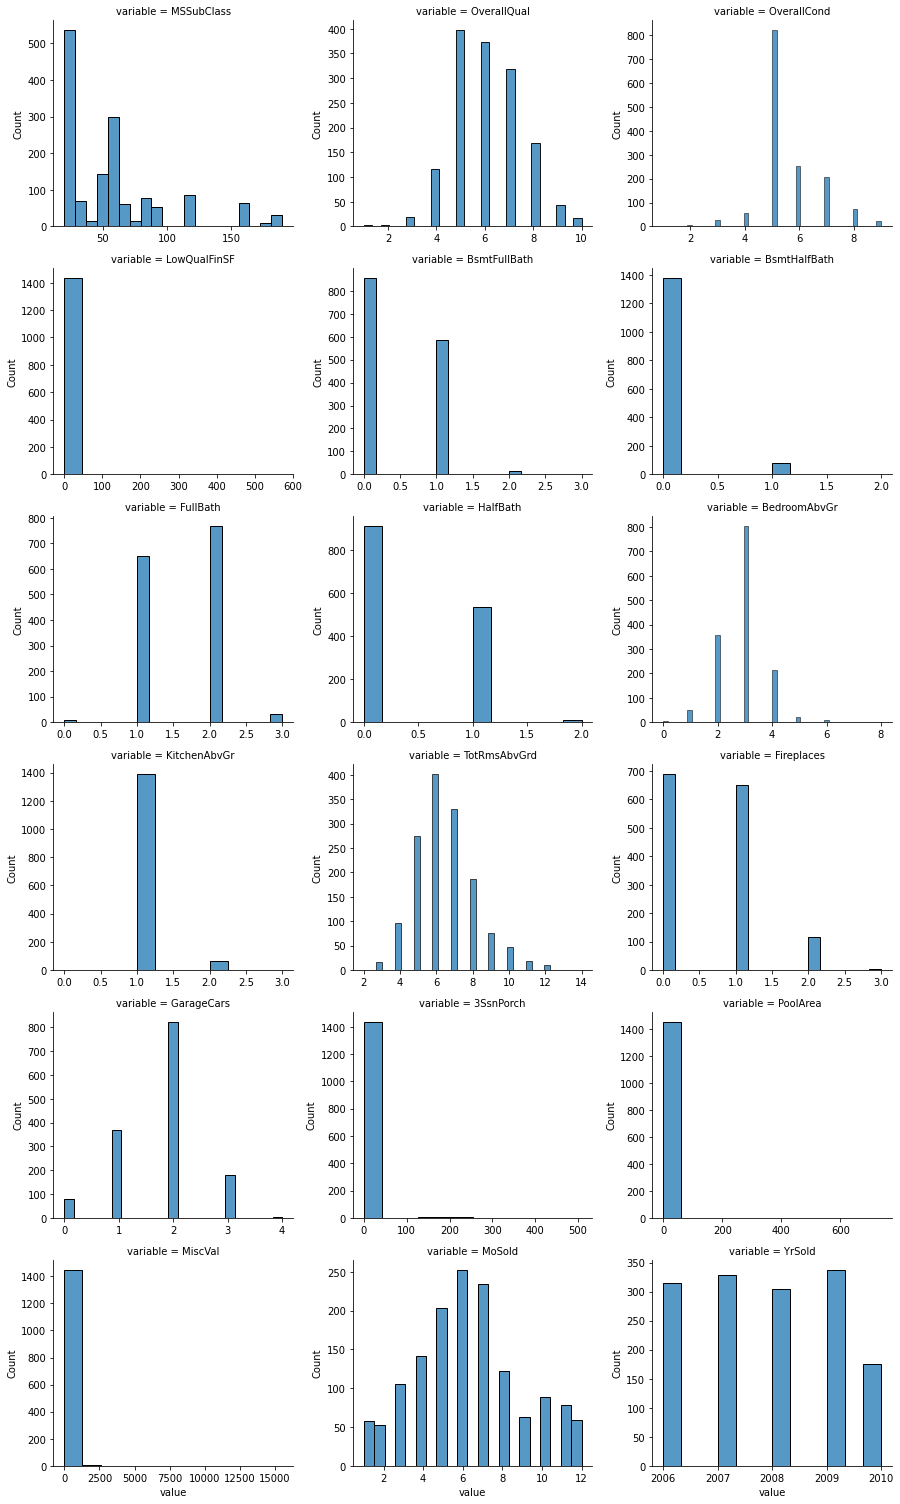

In [18]:
f = pd.melt(df_train[numerical_features_less_30])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
fg.map(sns.histplot, "value")

In [19]:
numerical_features_less_30 = ['OverallQual', 'TotRmsAbvGrd', 'MoSold', 'YrSold', 'GarageCars']
# drop_cols = [x for x in numerical_features if x not in (numerical_features_more_30 and numerical_features_less_30)]

In [20]:
# df_train.drop(columns = drop_cols,inplace=True)

### Categorical

In [21]:
# This function presents all the boxplots of categorical preditors with SalePrice
def srt_box(y, df):
    fig, axes = plt.subplots(11, 3, figsize=(20, 70))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['category']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=True)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

In [22]:
categorical = categorical_features + numerical_features_less_30
df_categorical = df_train[categorical].astype('category',copy=False)
df_categorical['SalePrice'] = df_train['SalePrice']
df_categorical

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Functional,PavedDrive,SaleType,SaleCondition,OverallQual,TotRmsAbvGrd,MoSold,YrSold,GarageCars,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,Y,WD,Normal,7,8,2,2008,2,1.252435
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Typ,Y,WD,Normal,6,6,5,2007,2,1.103199
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,Y,WD,Normal,7,6,9,2008,2,1.335344
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Typ,Y,WD,Abnorml,7,7,2,2006,3,0.873818
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Typ,Y,WD,Normal,8,9,12,2008,3,1.481817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Typ,Y,WD,Normal,6,7,8,2007,2,1.067272
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,Min1,Y,WD,Normal,6,7,2,2010,2,1.260726
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Typ,Y,WD,Normal,7,9,5,2010,1,1.573017
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Typ,Y,WD,Normal,5,5,4,2010,1,0.885563


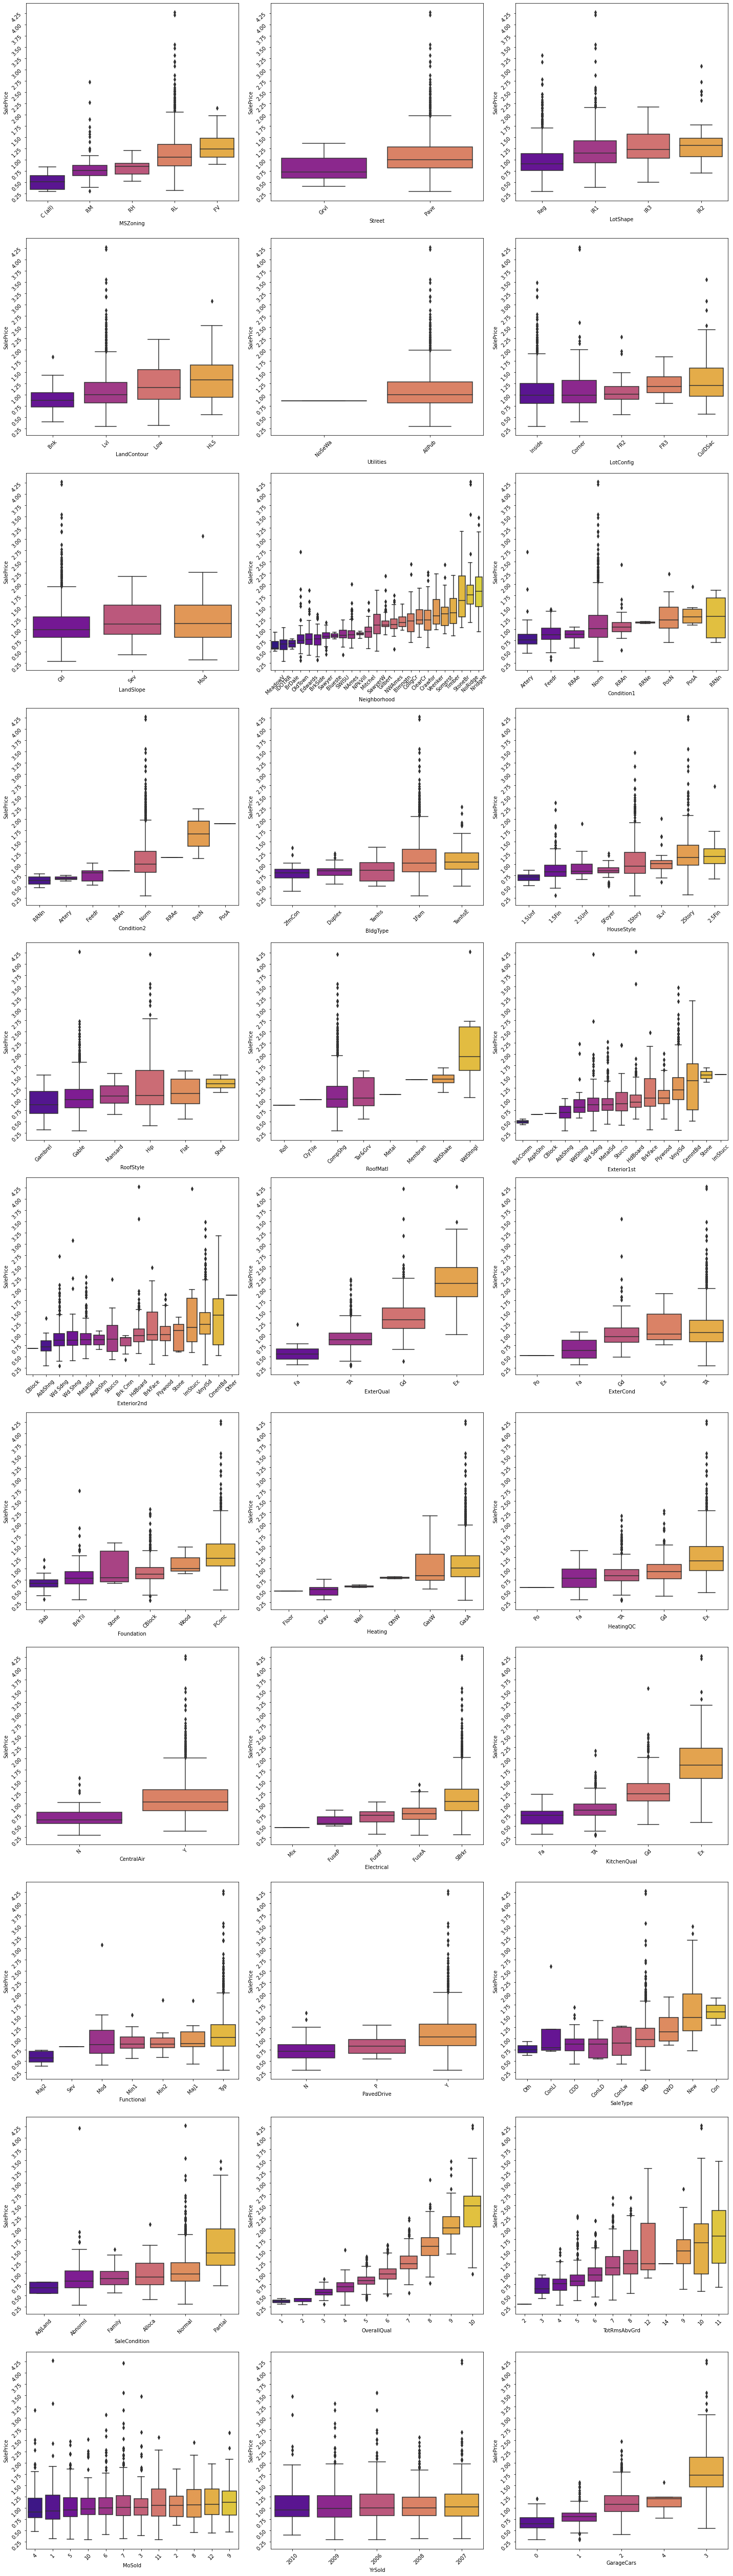

In [23]:
srt_box('SalePrice', df_categorical)

In [24]:
categorical_features = ['Neighborhood','ExterQual','CentralAir','KitchenQual','OverallQual','GarageCars']
target_feature = ['SalePrice'] + categorical_features + numerical_features_more_30
tmp = df_train[target_feature] 
tmp

,SalePrice,Neighborhood,ExterQual,CentralAir,KitchenQual,OverallQual,GarageCars,LotArea,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
0,1.252435,CollgCr,Gd,Y,Gd,7,2,-0.101508,-0.091731,-0.178811,0.205686,0.256279
1,1.103199,Veenker,TA,Y,TA,6,2,0.012741,0.282285,0.170142,-0.069620,0.072362
2,1.335344,CollgCr,Gd,Y,Gd,7,2,0.156759,-0.030098,-0.115061,0.245701,0.380476
3,0.873818,Crawfor,TA,Y,Gd,7,3,0.008036,-0.190488,-0.076259,0.209439,0.450467
4,1.481817,NoRidge,Gd,Y,Gd,8,3,0.375639,0.178297,0.081431,0.438501,0.845180
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.067272,Gilbert,TA,Y,TA,6,2,-0.159238,0.001242,-0.083713,0.171257,0.072362
1456,1.260726,NWAmes,TA,Y,TA,6,2,0.302143,0.521226,0.632883,0.383832,0.156238
1457,1.573017,Crawfor,Ex,Y,Gd,7,1,-0.041067,0.184596,0.114956,0.497182,-0.373171
1458,0.885563,NAmes,TA,Y,Gd,5,1,0.023666,0.117476,0.026847,-0.209076,-0.399481


In [25]:
# Converting the important categorical columns to numeric ones.

# neighborhood
nbd_map = {
    'MeadowV': 1,
    'IDOTRR':  1,
    'BrDale':  1,
    'BrkSide': 1,
    'OldTown': 1,
    'Edwards': 2,
    'Sawyer':  2,
    'Blueste': 2,
    'SWISU':   2,
    'NPkVill': 2,
    'NAmes':   3,
    'Mitchel': 3,
    'SawyerW': 3,
    'NWAmes':  3,
    'Gilbert': 3,
    'Blmngtn': 4,
    'CollgCr': 4,
    'ClearCr': 4,
    'Crawfor': 4,
    'Veenker': 4,
    'Somerst': 5,
    'Timber':  5,
    'StoneBr': 5,
    'NridgHt': 5,
    'NoRidge': 5
}
tmp['Neighborhood'] = tmp['Neighborhood'].map(nbd_map).astype('int')

# ExterQual
EQ_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
tmp['ExterQual'] = tmp['ExterQual'].map(EQ_map).astype('int')

# CentralAir
CA_map = {'N': 0, 'Y': 1}
tmp['CentralAir'] = tmp['CentralAir'].map(CA_map).astype('int')

# KitchenQual
KQ_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
tmp['KitchenQual'] = tmp['KitchenQual'].map(KQ_map).astype('int')

# OverallQual
tmp['OverallQual'] = tmp['OverallQual'].astype('int')

# GarageCars
tmp['OverallQual'] = tmp['OverallQual'].astype('int')

/tmp/ipykernel_35802/3502752487.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Neighborhood'] = tmp['Neighborhood'].map(nbd_map).astype('int')
/tmp/ipykernel_35802/3502752487.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ExterQual'] = tmp['ExterQual'].map(EQ_map).astype('int')
/tmp/ipykernel_35802/3502752487.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [26]:
tmp.dtypes

SalePrice       float64
Neighborhood      int64
ExterQual         int64
CentralAir        int64
KitchenQual       int64
OverallQual       int64
GarageCars        int64
LotArea         float64
TotalBsmtSF     float64
1stFlrSF        float64
GrLivArea       float64
GarageArea      float64
dtype: object

### Correlations

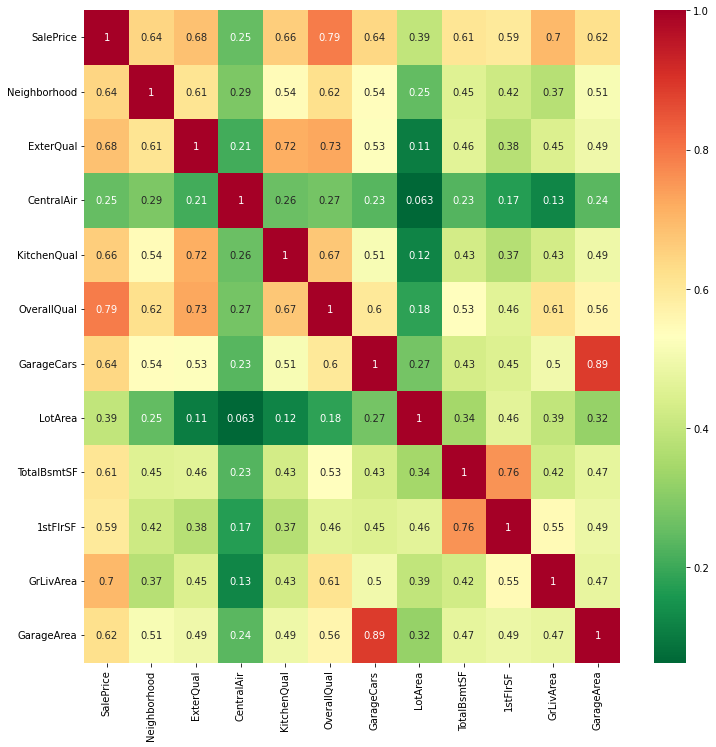

In [27]:
corrmat = tmp.corr()
plt.figure(figsize=(12,12))
g = sns.heatmap(tmp.corr(),annot=True,cmap="RdYlGn_r")

Since the correlation between `SalePrice` with both `CentralAir` and `LotArea` are less than 0.5, we decided to drop these two predictors before fitting the model.

In [28]:
tmp.drop(columns = ['CentralAir', 'LotArea'], inplace=True)
df_train_clean = tmp
df_train_clean

/tmp/ipykernel_35802/258036641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.drop(columns = ['CentralAir', 'LotArea'], inplace=True)


,SalePrice,Neighborhood,ExterQual,KitchenQual,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
0,1.252435,4,4,4,7,2,-0.091731,-0.178811,0.205686,0.256279
1,1.103199,4,3,3,6,2,0.282285,0.170142,-0.069620,0.072362
2,1.335344,4,4,4,7,2,-0.030098,-0.115061,0.245701,0.380476
3,0.873818,4,3,4,7,3,-0.190488,-0.076259,0.209439,0.450467
4,1.481817,5,4,4,8,3,0.178297,0.081431,0.438501,0.845180
...,...,...,...,...,...,...,...,...,...,...
1455,1.067272,3,3,3,6,2,0.001242,-0.083713,0.171257,0.072362
1456,1.260726,3,3,3,6,2,0.521226,0.632883,0.383832,0.156238
1457,1.573017,4,5,4,7,1,0.184596,0.114956,0.497182,-0.373171
1458,0.885563,3,3,4,5,1,0.117476,0.026847,-0.209076,-0.399481
